#### Bayesian Data Analysis Project (BDA) - 2018

# Analysis of House Prices through Supervised Bayesian Linear Modelling

## 1. Data Analysis

This section of the report will briefly highlight some of the characteristics of the dataset chosen from Kaggle. In addition to this, some figures and illustrations will be provided to support how the distribution of features and labels in the training data will affect the Stan modelling.

We start this section with importing all the necessary packages and importing the dataset to better visualize it and see all the features and labels in it. 

In [1]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import psis
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.special import logsumexp


# Import from Stan utilities
import stan_utility

In [2]:
# Import dataset and view a part of it
df = pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


As can be seen from a portion of the dataset provided above, there are a total of 19 features of the house exluding the **price** which is the quantity we intended to infer from our model and the **id**. A total of 21613 obervations exist in the dataset.

The objective of our analysis is to find the relationships of all the features with the **price** of the house.
To acheive this feat, it is necessary to understand the distribution, nature and correlation of each feature with the **price** of the house. A good first step is the visualization of the house prices in all the observations. Some statistical indicators for the house prices are provided below:

Minimum House price:  75000.0 $
Maximum of House price:  7700000.0 $
Mean of House prices:  540088.1417665294

Mode of House prices: 


0    350000.0
1    450000.0
dtype: float64

Statistics about House Price: 


count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

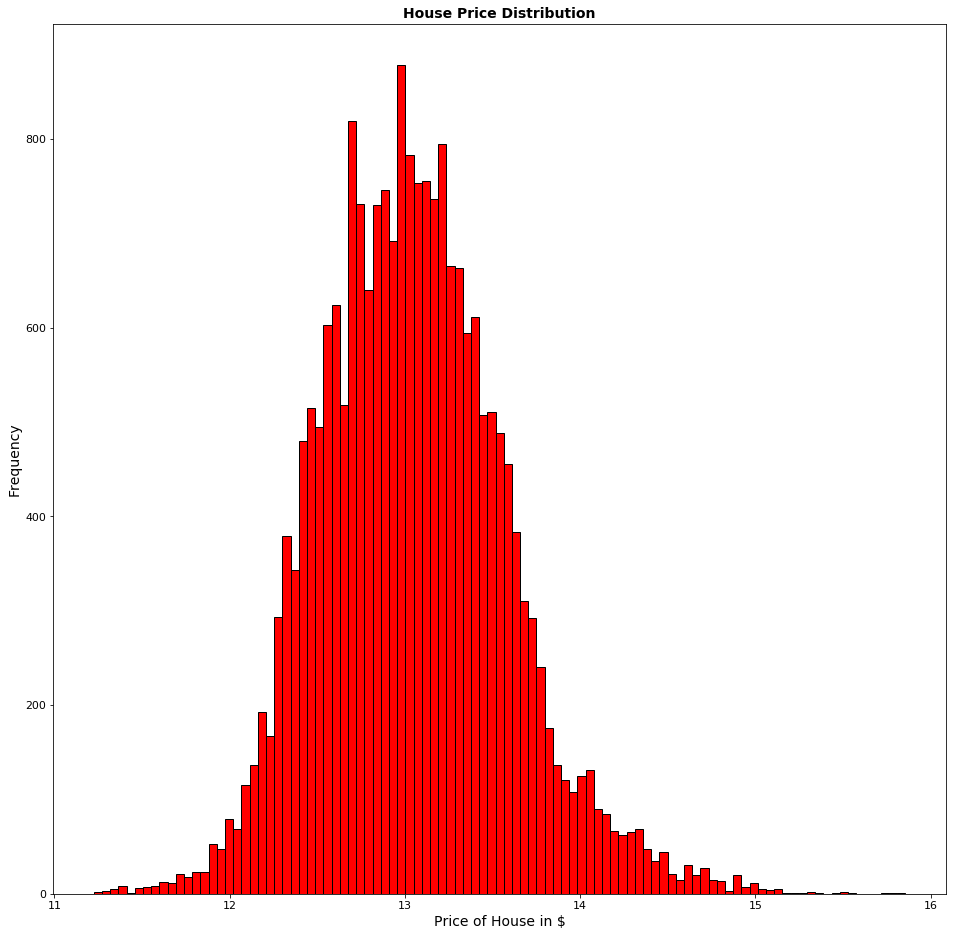

In [3]:
# Statistical Metrics for House Prices
minPrice = df.loc[:,'price'].min()
maxPrice = df.loc[:,'price'].max()
priceMean = df.loc[:,'price'].mean()
priceMode = df.loc[:,'price'].mode()
priceStats = df.loc[:,'price'].describe()

print("Minimum House price: ", minPrice, "$")
print("Maximum of House price: ", maxPrice, "$")

print("Mean of House prices: ", priceMean)
print("\nMode of House prices: ")
display(priceMode)

print("Statistics about House Price: ")
display(priceStats)

# Histogram of log of House Prices
fig = plt.figure(figsize = (16, 16))
plt.hist(np.log(df['price']), bins = 99, edgecolor = 'black', color = 'red')
plt.xlabel('Price of House in $', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.tick_params(labelsize = 11)
plt.title('House Price Distribution', fontsize = 14, fontweight = 'bold')
plt.savefig(f"logHist.jpg")

The statistical values along with the histogram clearly show that the prices are normally distributed with minimal skewness and most of the houses with prices 350k and 450k dollars. This provides reassurance that there will be no bias in the model as far as the house prices are concerned. The next step is to find the correlation of each feature with the price to understand the proportinalities between the two qunatities which would provide useful information for *Feature Selection*. Before this, the feature **date** and **id** will be discarded from the dataset as they do not significantly (or at all) affect the price of the houses.   

In [4]:
# Drop unnecessary columns are display the updated dataset
df = df.drop(['id', 'date'], axis = 1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
# Correlation of all the features with the price of the house
most_corr = df.corr()['price'].abs().sort_values(ascending = False)

# Feature count
F = 4

# Retain the top 4 most correlated features with the price
most_corr = most_corr[1:F + 1]

# Preparation of the data for the Stan Model (samples for convergence and predictions)
totalSamples = 2000
df = df.sample(n = totalSamples)

# Store the prices in the label set
labels = df['price']

# Trim down the dataframe to the desired number of features and without the labels ('price')
df = df.loc[:, most_corr.index]

As per the scope of the project and the size of the dataset, we have decided to shortlist a total of four features from the dataset with the highest magnitude of coorelation values for creating our Bayesian model. As can be seen from the correlation values, the three selected features are **sqft_living**, **grade**, **sqft_above**, and **sqft_living15**. The detailed descriptions of each of these features are as follows:

1. **sqft_living:** Square Footage of each home.
2. **grade:** Overall grade given to the housing unit based on King County grading system.
3. **sqft_above:** Square Footage of house apart from the basement.
4. **sqft_living15:** Living room area in 2015 (implies -- some renovations) This might or might not have affected the lotsize area

After selecting the best features, the dataset has been divided into a seperate *training set* (all selected features) and a *test set* (list of all labels, i.e., **price**). Morevover, a subsample of the dataset roughly 10% of the original one has been extracted randomly for creating the Bayesian Model. The split ratio for train and test sets has been set to *70:30*. In addition to this, the feature dataset has been scaled using the **Standard Scaler** to ensure that the mean and variance of the feature distribution stays close to 0 and 1 respectively.

In [59]:
# Create train and test splits for the features and labels
x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size = 0.1, random_state = 42)

# Type conversion of splits
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values

XTrain = x_train.astype(str).astype(float)
YTrain = y_train.ravel().astype(str).astype(float)
XTest = x_test.astype(str).astype(float)
YTest = y_test.ravel().astype(str).astype(float)

# Scaling of the train and test data for the model
scaler = StandardScaler()
scaler_new = StandardScaler()

XTrain_Scaled = scaler.fit_transform(XTrain)
XTest_Scaled = scaler.transform(XTest)

YTrain_Scaled = scaler_new.fit_transform(YTrain.reshape(-1,1)).ravel()
YTest_Scaled = scaler_new.transform(YTest.reshape(-1,1)).ravel()

# Input data for Stan model
data_poly = dict(
    tN = len(XTest_Scaled),
    N = len(XTrain_Scaled),
    F = F,
    y = YTrain_Scaled,
    x = XTrain_Scaled,
    x_2 = np.square(XTrain_Scaled),
    x_test = XTest_Scaled,
    x_test_2 = np.square(XTest_Scaled)
)

# Input data for Stan model
data_linear = dict(
    tN = len(XTest_Scaled),
    N = len(XTrain_Scaled),
    F = F,
    y = YTrain_Scaled,
    x = XTrain_Scaled,
    x_test = XTest_Scaled
)

## 2. Bayesian Modelling

 - Here we discuss the model selected for the problem based on the data analysis (to do)
 - Explain the Stan model and show how it runs (both need to specifically mentioned)
 - Justify the selection of priors (to do)
 - Provide the results (done)
 - Posterior Predictive Checking (done somewhat) 

The regression model provides a regression equation where the coefficients represent the relation between the independent values(features) and the dependent value(price). This is best model we can use to predict house prices.

We are comparing the Linear regression Model and the Polyomial regression model of order 2 in order to find out which model is more appropriate for our data.

Here, we have used weakly informative priors as defined in Gelman 2008. The idea behind this prior is that most of the effects (slopes) are small and a few are big, therefore the cauchy distribution with mean 0 and a long tail is used. 

In our Stan model we first construct the data block, which includes the features, prices of the training set and their count, features of the test set and their count.  We then initialize our parameters which in our case are the intercept,slope values and the variance. The intercept and slope parameters are transformed into another parameter which can be considered as the mean of the price distribution. 

We model the house prices as a normal sample with a mean that is the transformed parameter computed earlier. 

Once the model is fit, the parameters are used to predict the house prices of the test set and also the log likelihood values are generated in order to calculate the PSIS-LOO values. 



In [51]:
# Stan Pooled model compilation 
model_linear = stan_utility.compile_model(filename = 'model_trial.stan', model_name = 'linear')
model_poly = stan_utility.compile_model(filename = 'model_trial_2.stan', model_name = 'polynomial')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_23307f82cce8b5150747ec40c2ddb2a2 NOW.
/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpa1evvij2/stanfit4anon_model_23307f82cce8b5150747ec40c2ddb2a2_3566657965154540145.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fdf10200661fa3c5ef96589091fabb87 NOW.
/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpviv6kd9c/stanfit4anon_model_fdf10200661fa3c5ef96589091fabb87_2380164154590665983.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [60]:
#Linear model
fit_linear = model_linear.sampling(data = data_linear, seed = 194838, n_jobs = -1)
print(fit_linear)
samples_linear = fit_linear.extract(permuted = True)

stan_utility.check_treedepth(fit_linear)

Inference for Stan model: anon_model_23307f82cce8b5150747ec40c2ddb2a2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept       -2.5e-4  2.3e-4   0.02  -0.03  -0.01-4.4e-4   0.01   0.03   4695    1.0
theta[1]            0.6  6.6e-4   0.04   0.52   0.57    0.6   0.62   0.67   3516    1.0
theta[2]           0.26  4.1e-4   0.03   0.21   0.24   0.26   0.28   0.31   4152    1.0
theta[3]          -0.14  6.0e-4   0.04  -0.21  -0.16  -0.14  -0.11  -0.06   3751    1.0
theta[4]           0.05  3.8e-4   0.03-3.0e-3   0.03   0.05   0.06    0.1   4576    1.0
sigma              0.68  1.6e-4   0.01   0.66   0.67   0.68   0.69    0.7   4583    1.0
y_mean[1]          1.37  6.0e-4   0.04   1.29   1.34   1.37    1.4   1.45   4645    1.0
y_mean[2]         -0.27  4.7e-4   0.03  -0.33  -0.29  -0.27  -0.25  -0.21   4533    1.0
y_mean[3]          

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)


In [53]:
# Model fitting with default parameters and displaying the results 

fit_poly = model_poly.sampling(data = data_poly, seed = 194838, n_jobs = -1)
print(fit_poly)

# Extraction for posterior predictive samples from the model
samples_poly = fit_poly.extract(permuted = True)

Inference for Stan model: anon_model_fdf10200661fa3c5ef96589091fabb87.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept         -0.15  2.9e-4   0.02  -0.18  -0.16  -0.15  -0.14  -0.11   3964    1.0
theta[1]           0.38  8.2e-4   0.04    0.3   0.36   0.38   0.41   0.46   2403    1.0
theta[2]           0.29  3.9e-4   0.02   0.24   0.27   0.29   0.31   0.34   3840    1.0
theta[3]          -0.24  7.5e-4   0.04  -0.32  -0.27  -0.24  -0.22  -0.17   2578    1.0
theta[4]           0.14  4.8e-4   0.03   0.09   0.13   0.14   0.16    0.2   3075    1.0
theta[5]           0.13  3.1e-4   0.02    0.1   0.12   0.13   0.14   0.16   2538    1.0
theta[6]           0.03  1.8e-4   0.01 8.9e-3   0.02   0.03   0.04   0.05   4101    1.0
theta[7]         2.4e-3  2.8e-4   0.01  -0.03-7.4e-3 2.5e-3   0.01   0.03   2662    1.0
theta[8]          -

In [54]:
# Ensuring that parameters to the Stan model are fine tuned
stan_utility.check_treedepth(fit_poly)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)


In [61]:
# Extract the predictive posterior values from the model and the orginial 'Price' value from the dataset 
y_ax_linear = samples_linear['y_predicted'].mean(axis=0)
y_ax_poly = samples_poly['y_predicted'].mean(axis = 0)

'''
    Extract a fraction (30%) of the predictive posterior values
    from the test samples and original samples for nice plots 
'''
predictionSamples = int(len(YTest_Scaled) * 0.3)
x_ax = np.arange(1, predictionSamples + 1, 1)

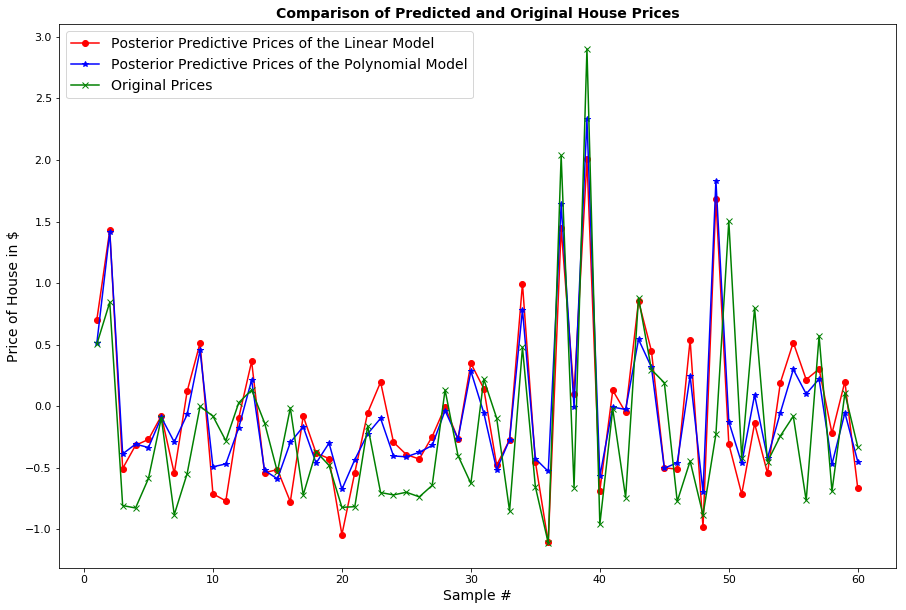

In [62]:
# Plot the predictions versus the original values
fig = plt.figure(figsize = (15, 10))
plt.xlabel('Sample #', fontsize = 14)
plt.ylabel('Price of House in $', fontsize = 14)
plt.plot(x_ax, y_ax_linear[:predictionSamples], label = "Posterior Predictive Prices of the Linear Model", marker = 'o', c = 'red')
plt.plot(x_ax, y_ax_poly[:predictionSamples], label = "Posterior Predictive Prices of the Polynomial Model", marker = '*', c = 'blue')
plt.plot(x_ax, YTest_Scaled[:predictionSamples], label = "Original Prices", marker = 'x', c = 'green')
plt.legend(fontsize = 14)
plt.tick_params(labelsize = 11)
plt.title('Comparison of Predicted and Original House Prices', fontsize = 14, fontweight = 'bold')
plt.savefig(f"priceCompare.jpg")

In [65]:
#Root Mean squared error
rms_poly = 0
rms_linear = 0
for i in range(0,np.size(YTest_Scaled)):
    rms_poly = rms_poly + np.sqrt(np.abs(YTest_Scaled[i] - y_ax_poly[i]))
    rms_linear = rms_linear + np.sqrt(np.abs(YTest_Scaled[i] - y_ax_linear[i]))
    
rms_poly = rms_poly/predictionSamples
rms_linear = rms_linear/predictionSamples

print("Root Mean squared error of the Linear model: ",rms_linear)
print("Root Mean squared error of the Polynomial model: ", rms_poly)

Root Mean squared error of the Linear model:  1.9984432082387649
Root Mean squared error of the Polynomial model:  1.8125691994432933


In [67]:
log_lik_poly = samples_poly["loglik_pred"]
log_lik_linear = samples_linear["loglik_pred"]
loo_linear,loos_linear,ks_linear=psis.psisloo(log_lik_linear)
loo_poly,loos_poly,ks_poly=psis.psisloo(log_lik_poly)

print("Polynomial Model : ")
print("PSIS-LOO value:",loo_poly)

lppd_poly=np.sum(logsumexp(log_lik_poly,axis=0,b=1./log_lik_poly.shape[0]))
p_loo_poly=lppd_poly-loo_poly
print("Estimated effective number of parameters in the model: ",p_loo_poly)

ksn1=(ks_poly>=0.7).sum()
print("No of k values greater than 0.7 : ", ksn1)

Polynomial Model : 
PSIS-LOO value: -240.51474017780686
Estimated effective number of parameters in the model:  25.636759923522504
No of k values greater than 0.7 :  1


In [70]:
print("Linear Model : ")
print("PSIS-LOO value:",loo_linear)

lppd_linear=np.sum(logsumexp(log_lik_linear,axis=0,b=1./log_lik_linear.shape[0]))
p_loo_linear=lppd_linear-loo_linear
print("Estimated effective number of parameters in the model: ",p_loo_linear)

ksn2=(ks>=0.7).sum()
print("No of k values greater than 0.7 : ", ksn2)

Linear Model : 
PSIS-LOO value: -357.2410135288971
Estimated effective number of parameters in the model:  27.703360908248783
No of k values greater than 0.7 :  1


Text(0.5, 1.0, 'Pareto k estimates')

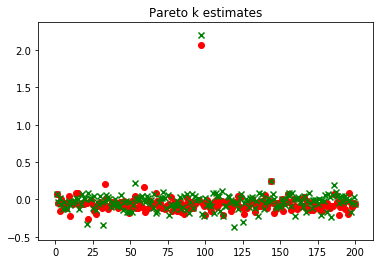

In [69]:
x_linear = np.arange(1, np.size(ks_linear)+1, 1)
x_poly = np.arange(1, np.size(ks_poly)+1, 1)

plt.scatter(x_linear,ks_linear, label = "Pareto k estimates", marker = 'o', c = 'red')
plt.scatter(x_poly,ks_poly, label = "Pareto k estimates", marker = 'x', c = 'green')
plt.title("Pareto k estimates")

From the Pareto k estimates we can see that both the models are reliable(only one k values is more than 0.7)

The model with the highest PSIS-LOO values is the Polynomial Regresion Model of order 2. Hence we choose this model as the most appropriate for this dataset. 



## 3. Comparative Analysis of Model

 - Model comparison using loo (to do)
 - Predictive performance assesment (to do)
 - Potential sensitivity analysis (to do) 

## 4. Conclusion

 - What we acheived (to do)
 - Discussion of problems/limitations (to do)
 - Future improvements (to do)